# Maternal Health Risk Prediction with Explainability
This notebook improves the prediction of maternal health risks using a Random Forest classifier and integrates SHAP for explainability.

### Key Features:
- **Improved Low-Risk Predictions:** Addressed class imbalance using SMOTE.
- **SHAP Explainability:** Added explanations for "High Risk" and "Mid Risk" predictions.
- **Manual Input:** Allows users to input custom values and predict their risk level.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

C:\Users\Abhin M\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load data
df = pd.read_csv('New Maternal Health Risk Data Set .csv')
X = df.drop(columns='RiskLevel')
y = df['RiskLevel']
X = pd.get_dummies(X)
y = y.map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

# Handle missing values by filling them with the mean of each column
X = X.fillna(X.mean())

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       160
           1       0.84      0.84      0.84       162
           2       0.92      0.87      0.89       156

    accuracy                           0.85       478
   macro avg       0.85      0.85      0.85       478
weighted avg       0.85      0.85      0.85       478



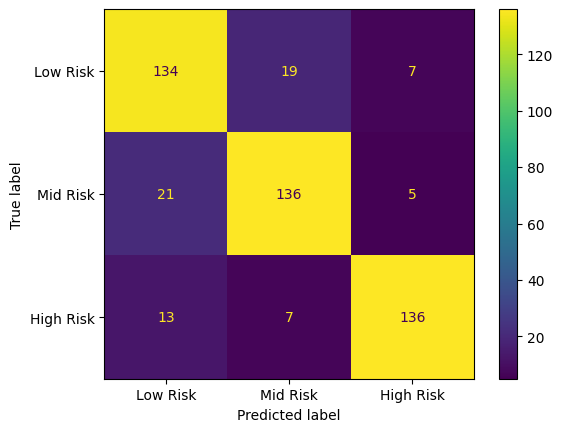

In [8]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'Mid Risk', 'High Risk'])
disp.plot()
plt.show()

In [9]:
# SHAP explainability
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

<Figure size 640x480 with 0 Axes>

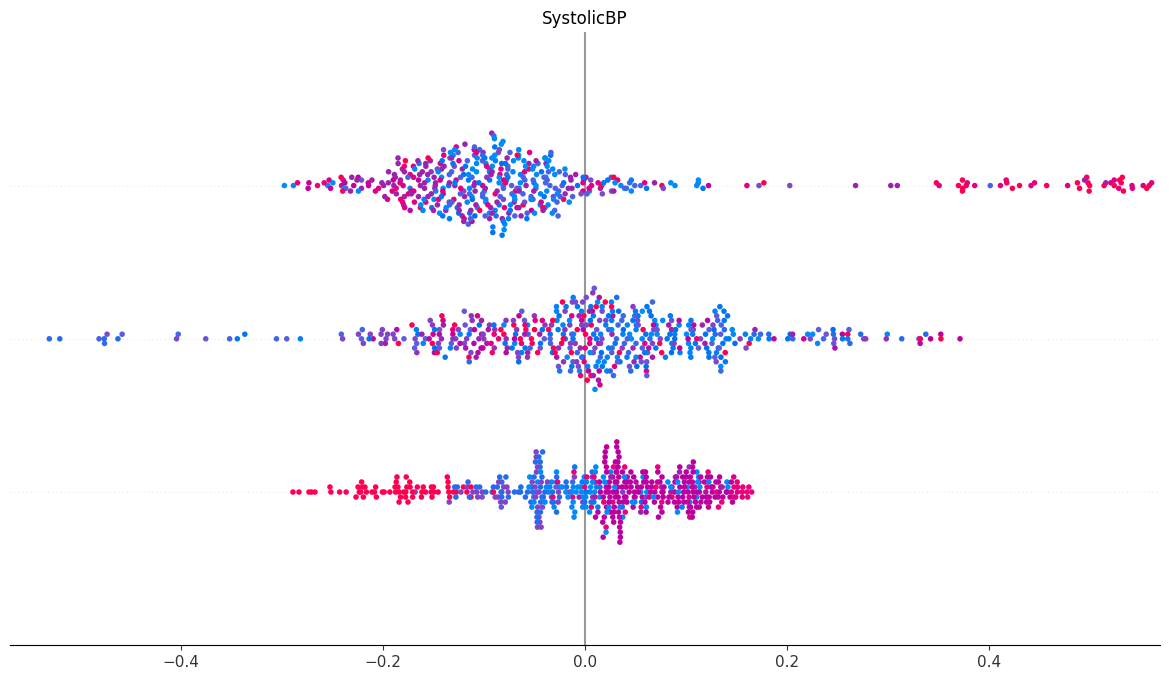

In [10]:
# SHAP summary plot (overall feature importance)
shap.summary_plot(shap_values, X_test)

In [ ]:
# Explain High-Risk and Mid-Risk predictions
def explain_predictions(indices, risk_level, shap_values, X_test):
    for i in indices:
        if i >= len(shap_values[risk_level]):  # Skip invalid indices
            print(f"Index {i} is out of bounds for SHAP values. Skipping...")
            continue
        instance = X_test.iloc[i]
        shap_vals = shap_values[risk_level][i]  # Corresponds to the risk level index
        top_indices = np.argsort(np.abs(shap_vals))[-3:]  # Top 3 features
        print(f"\n🩺 Prediction Explanation for Sample {i} (Risk Level: {'High Risk' if risk_level == 2 else 'Mid Risk'}):")
        for idx in reversed(top_indices):
            feature_name = X_test.columns[idx]
            feature_value = instance[feature_name]
            contribution = shap_vals[idx]
            direction = "increased" if contribution > 0 else "decreased"
            print(f" - {feature_name} = {feature_value} → {direction} the risk")

# Recalculate SHAP values for the entire X_test to avoid mismatch issues
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Ensure indices are within bounds of shap_values
high_risk_indices = [i for i, pred in enumerate(y_pred) if pred == 2]
high_risk_indices = [i for i in high_risk_indices if i < len(shap_values[2])]

mid_risk_indices = [i for i, pred in enumerate(y_pred) if pred == 1]
mid_risk_indices = [i for i in mid_risk_indices if i < len(shap_values[1])]


# Explain High-Risk predictions
explain_predictions(high_risk_indices, risk_level=2, shap_values=shap_values, X_test=X_test)

# Explain Mid-Risk predictions
explain_predictions(mid_risk_indices, risk_level=1, shap_values=shap_values, X_test=X_test)


🩺 Prediction Explanation for Sample 0 (Risk Level: High Risk):
 - SystolicBP = 130.0 → increased the risk
 - DiastolicBP = 100.0 → decreased the risk
 - Age = 50.0 → decreased the risk

🩺 Prediction Explanation for Sample 3 (Risk Level: High Risk):
 - DiastolicBP = 100.0 → decreased the risk
 - SystolicBP = 130.0 → increased the risk
 - Age = 50.0 → increased the risk

🩺 Prediction Explanation for Sample 1 (Risk Level: Mid Risk):
 - DiastolicBP = 50.0 → decreased the risk
 - Age = 12.0 → increased the risk
 - SystolicBP = 100.0 → increased the risk

🩺 Prediction Explanation for Sample 2 (Risk Level: Mid Risk):
 - SystolicBP = 123.01377874164142 → increased the risk
 - Age = 31.0 → decreased the risk
 - DiastolicBP = 66.50688937082072 → decreased the risk


In [12]:
# Manual input for prediction
import numpy as np

# Define the input schema based on your dataset's features
# Example: ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
manual_input = {
    'Age': 23,
    'SystolicBP': 130,
    'DiastolicBP': 70,
    'BS': 7.01,
    'BodyTemp': 98,
    'HeartRate': 78
}

# Convert the manual input to a DataFrame (to match the model's input format)
manual_input_df = pd.DataFrame([manual_input])

# Ensure any preprocessing (e.g., scaling, encoding) matches that used during training
# Example: If you applied get_dummies or scaling, do the same here
# Ensure the same column order as the training data
manual_input_df = pd.get_dummies(manual_input_df)
for col in X.columns:  # Ensure all columns in training data are present
    if col not in manual_input_df.columns:
        manual_input_df[col] = 0  # Add missing columns with a default value
manual_input_df = manual_input_df[X.columns]  # Match the training data column order

# Make prediction
prediction = rf_model.predict(manual_input_df)[0]  # Get the predicted class
prediction_proba = rf_model.predict_proba(manual_input_df)  # Get probabilities for each class

# Map the predicted class back to the risk level
risk_map = {0: 'Low Risk', 1: 'Mid Risk', 2: 'High Risk'}
predicted_risk = risk_map[prediction]

# Output the result
print(f"🩺 Manual Input Prediction:\n - Predicted Risk Level: {predicted_risk}")
print(f" - Prediction Probabilities: {prediction_proba[0]}")

🩺 Manual Input Prediction:
 - Predicted Risk Level: Mid Risk
 - Prediction Probabilities: [0.40908333 0.59091667 0.        ]


In [13]:

import gradio as gr
import pandas as pd
import numpy as np

# Define the model (assuming it's already trained)
# rf_model = <your trained random forest model>
# X = <your training dataset features>

# Define a function for prediction
def predict_risk(Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate):
    # Create a DataFrame from the input values
    manual_input = {
        'Age': Age,
        'SystolicBP': SystolicBP,
        'DiastolicBP': DiastolicBP,
        'BS': BS,
        'BodyTemp': BodyTemp,
        'HeartRate': HeartRate
    }
    manual_input_df = pd.DataFrame([manual_input])

    # Ensure preprocessing matches training
    manual_input_df = pd.get_dummies(manual_input_df)
    for col in X.columns:  # Ensure all columns in training data are present
        if col not in manual_input_df.columns:
            manual_input_df[col] = 0  # Add missing columns with default value
    manual_input_df = manual_input_df[X.columns]  # Match column order

    # Predict risk
    prediction = rf_model.predict(manual_input_df)[0]
    prediction_proba = rf_model.predict_proba(manual_input_df)

    # Map prediction to risk level
    risk_map = {0: 'Low Risk', 1: 'Mid Risk', 2: 'High Risk'}
    predicted_risk = risk_map[prediction]

    return f"Predicted Risk Level: {predicted_risk}", f"Prediction Probabilities: {prediction_proba[0]}"

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_risk,
    inputs=[
         gr.Slider(18, 100, step=1, value=30, label="Age"),
        gr.Slider(80, 200, step=1, value=120, label="SystolicBP"),
        gr.Slider(50, 150, step=1, value=80, label="DiastolicBP"),
        gr.Slider(3.0, 20.0, step=0.1, value=7.5, label="BS"),
        gr.Slider(95.0, 105.0, step=0.1, value=98.6, label="BodyTemp"),
        gr.Slider(40, 200, step=1, value=75, label="HeartRate"),
    ],
    outputs=["text", "text"],
    live=True
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
